<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/PACF/PACF_and_SARIMAX_differenced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)
df['DT'] = pd.to_datetime(df['DT'])
df = df.set_index('DT')
df = df.iloc[::-1]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Axes: xlabel='DT'>

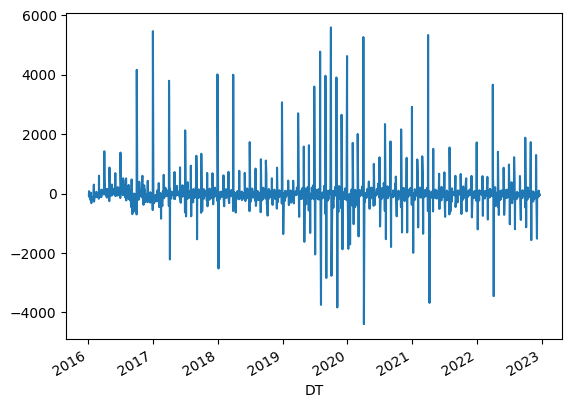

In [ ]:
df_copy = df
df_copy['ANTAL_01'] = df_copy['ANTAL_01'].astype(float) - df_copy['ANTAL_01'].astype(float).shift(1)
df_copy['ANTAL_01'].dropna().plot()

In [ ]:
df_copy.dropna()

,ANTAL_01
DT,
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0
2016-01-08,-35.0
...,...
2022-12-15,101.0
2022-12-16,-67.0
2022-12-19,-61.0


In [ ]:
#training and test
training = df_copy.iloc[:-16,:]
print(training.index)
testing = df_copy.iloc[-16:, :]
training.head()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1802, freq=None)


,ANTAL_01
DT,
2015-12-31,NaN
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0


In [ ]:
pacf = sm.tsa.pacf(training['ANTAL_01'].dropna(), nlags=262)

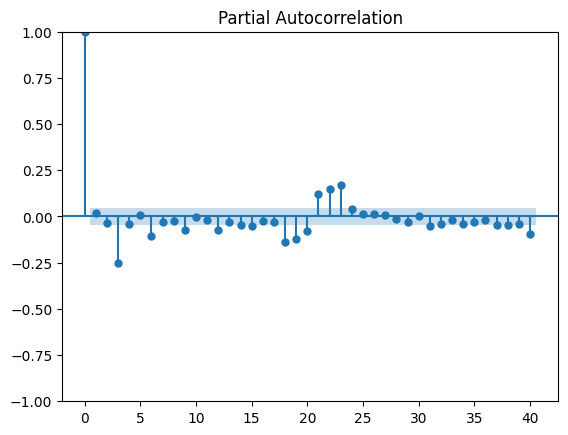

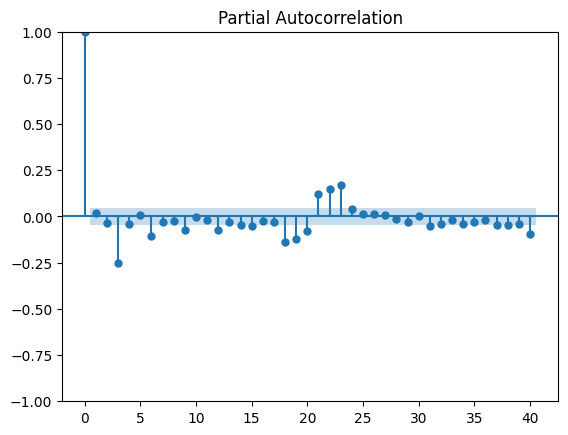

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(training.dropna(), lags = 40, method = "ols")

In [ ]:
training.dropna()

,ANTAL_01
DT,
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0
2016-01-08,-35.0
...,...
2022-11-23,-83.0
2022-11-24,-74.0
2022-11-25,29.0


In [ ]:
# repeat the ACF values until it matches the length of the training dataset
pacf_repeated = np.tile(pacf, int(np.ceil(len(training) / len(pacf))))[:len(training)]
pacf_repeated

array([ 1.        ,  0.01848583, -0.03334871, ..., -0.04400545,
        0.01323597, -0.01472152])

In [ ]:
# create a DataFrame with the repeated ACF values as a column
exog = pd.DataFrame({'pacf': pacf_repeated}, index=training.index)
exog

,pacf
DT,
2015-12-31,1.000000
2016-01-04,0.018486
2016-01-05,-0.033349
2016-01-06,-0.250490
2016-01-07,-0.039679
...,...
2022-11-23,-0.039308
2022-11-24,-0.008004
2022-11-25,-0.044005


In [ ]:
# drop any rows with missing values from the exog dataframe
exog = exog.dropna()
exog

,pacf
DT,
2015-12-31,1.000000
2016-01-04,0.018486
2016-01-05,-0.033349
2016-01-06,-0.250490
2016-01-07,-0.039679
...,...
2022-11-23,-0.039308
2022-11-24,-0.008004
2022-11-25,-0.044005


In [ ]:
np.asarray(training)

array([[  nan],
       [ -58.],
       [  82.],
       ...,
       [  29.],
       [ -14.],
       [-148.]])

In [ ]:
# fit SARIMAX model with exogenous variable
model = sm.tsa.SARIMAX(training['ANTAL_01'].astype(float), exog=np.asarray(exog), order=(3,0,3), seasonal_order=(3,0,3,22))
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
exogTest = exog.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2['pacf'])
exogvar = np.asarray(exogTest2['pacf'])
# make predictions with the fitted model and exogenous variables for test dataset
test_exog = pd.DataFrame({'pacf': exogvar}, index=testing.index)
test_exog

,pacf
DT,
2022-11-30,0.004887
2022-12-01,-0.010692
2022-12-02,0.002449
2022-12-05,0.007751
2022-12-06,-0.009759
2022-12-07,-0.024739
2022-12-08,-0.018695
2022-12-09,-0.014034
2022-12-12,-0.019571


In [ ]:
# predict using SARIMAX model
pred = result.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


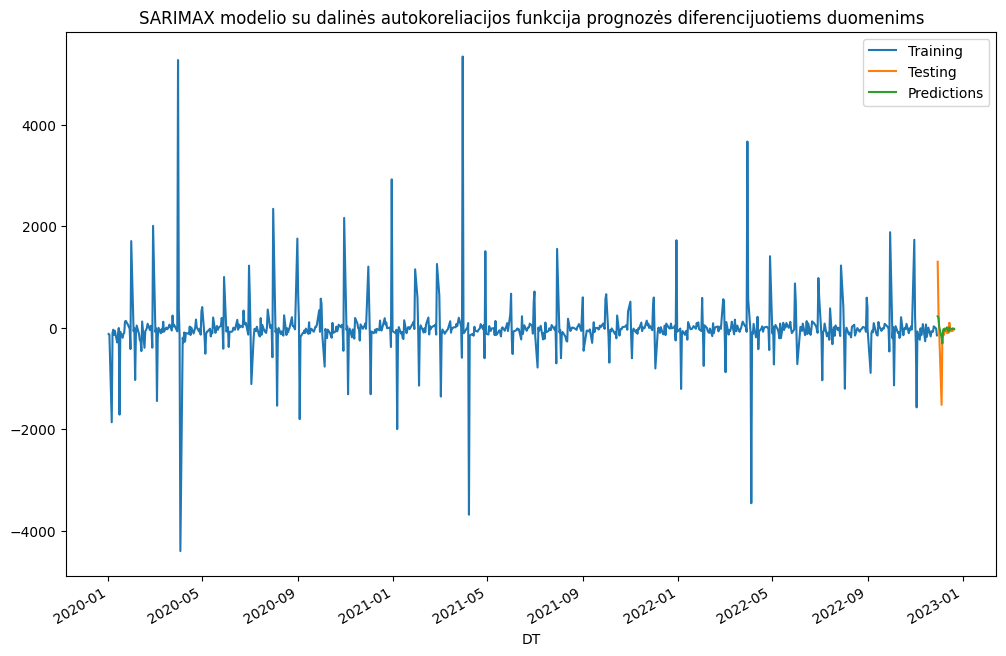

In [ ]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su dalinės autokoreliacijos funkcija prognozės diferencijuotiems duomenims')
plt.legend()

In [ ]:
pred, testing['ANTAL_01']

(DT
 2022-11-30    227.107802
 2022-12-01    195.764492
 2022-12-02     11.166586
 2022-12-05   -186.637999
 2022-12-06   -306.574751
 2022-12-07    -39.395290
 2022-12-08    -21.544789
 2022-12-09    -57.337915
 2022-12-12     10.524477
 2022-12-13    -28.898185
 2022-12-14    -70.534418
 2022-12-15      8.728199
 2022-12-16    -38.144502
 2022-12-19    -10.132000
 2022-12-20    -22.243278
 2022-12-21    -19.807378
 Name: predicted_mean, dtype: float64,
 DT
 2022-11-30    1301.0
 2022-12-01     317.0
 2022-12-02    -106.0
 2022-12-05   -1516.0
 2022-12-06    -159.0
 2022-12-07    -153.0
 2022-12-08    -135.0
 2022-12-09     -11.0
 2022-12-12    -105.0
 2022-12-13     -62.0
 2022-12-14     -98.0
 2022-12-15     101.0
 2022-12-16     -67.0
 2022-12-19     -61.0
 2022-12-20     -31.0
 2022-12-21     -31.0
 Name: ANTAL_01, dtype: float64)

In [ ]:
predictions = pred
df['ANTAL_01'] = df['ANTAL_01'].astype(int)

In [ ]:
last_values = df.iloc[:-16,:]
last_value = last_values[-1:]
last_value
original_preds= []
for pred in predictions:
    pred_value = last_value + pred
    original_preds.append(pred_value)
    last_value = pred_value
print(original_preds)

[                ANTAL_01
DT                      
2022-11-29  31133.107802,                 ANTAL_01
DT                      
2022-11-29  31328.872294,                ANTAL_01
DT                     
2022-11-29  31340.03888,                 ANTAL_01
DT                      
2022-11-29  31153.400881,                ANTAL_01
DT                     
2022-11-29  30846.82613,                ANTAL_01
DT                     
2022-11-29  30807.43084,                 ANTAL_01
DT                      
2022-11-29  30785.886051,                 ANTAL_01
DT                      
2022-11-29  30728.548136,                 ANTAL_01
DT                      
2022-11-29  30739.072613,                 ANTAL_01
DT                      
2022-11-29  30710.174428,                ANTAL_01
DT                     
2022-11-29  30639.64001,                 ANTAL_01
DT                      
2022-11-29  30648.368209,                 ANTAL_01
DT                      
2022-11-29  30610.223707,                 ANTAL_0